In [26]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the *Emma* corpus.  We'll be looking at interpretability, speed, and consistency across methods.  The goal is to identify common themes in *Emma* on a per-paragraph basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

## Generating the tfidf matrix

In [27]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [28]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [42]:
topwords

,LSA
0,oh 97.61
0,yes 4.83
0,difference 1.58
0,thank 1.57
0,just 1.44
0,harriet 1.33
0,sorry 1.28
0,short 1.17
0,papa 1.15
0,cried 1.02


In [46]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [48]:
topwords

,LSA,LDA
0,oh 97.61,chapter 16.1
0,yes 4.83,emma 13.06
0,difference 1.58,mr 12.42
0,thank 1.57,harriet 11.9
0,just 1.44,oh 9.93
0,harriet 1.33,think 9.62
0,sorry 1.28,said 9.16
0,short 1.17,mrs 7.45
0,papa 1.15,elton 7.38
0,cried 1.02,quite 7.06


In [49]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [51]:
topwords

,LSA,LDA,NNMF
0,oh 97.61,chapter 16.1,oh 30.12
0,yes 4.83,emma 13.06,yes 0.52
0,difference 1.58,mr 12.42,sorry 0.16
0,thank 1.57,harriet 11.9,difference 0.15
0,just 1.44,oh 9.93,just 0.12
0,harriet 1.33,think 9.62,papa 0.12
0,sorry 1.28,said 9.16,week 0.11
0,short 1.17,mrs 7.45,short 0.11
0,papa 1.15,elton 7.38,recollect 0.1
0,cried 1.02,quite 7.06,letter 0.09


We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

# Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [52]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
               LSA           LDA             NNMF
0         oh 97.61  chapter 16.1         oh 30.12
0         yes 4.83    emma 13.06         yes 0.52
0  difference 1.58      mr 12.42       sorry 0.16
0       thank 1.57  harriet 11.9  difference 0.15
0        just 1.44       oh 9.93        just 0.12
0     harriet 1.33    think 9.62        papa 0.12
0       sorry 1.28     said 9.16        week 0.11
0       short 1.17      mrs 7.45       short 0.11
0        papa 1.15    elton 7.38    recollect 0.1
0       cried 1.02    quite 7.06      letter 0.09
Topic 1:
             LSA          LDA            NNMF
1       mr 58.13     oh 57.98         mr 7.29
1     emma 58.13   emma 17.62        mrs 4.26
1     said 50.37    mrs 15.44      elton 3.41
1      mrs 47.04   said 13.22  knightley 3.24
1     miss 37.68    yes 12.95     weston 3.15
1  harriet 35.13     mr 12.54       miss 2.99
1   weston 32.23    did 10.38  woodhouse 2.09
1    elton 27.93   miss 10.37       said 1.88
1       did 27.6  

A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

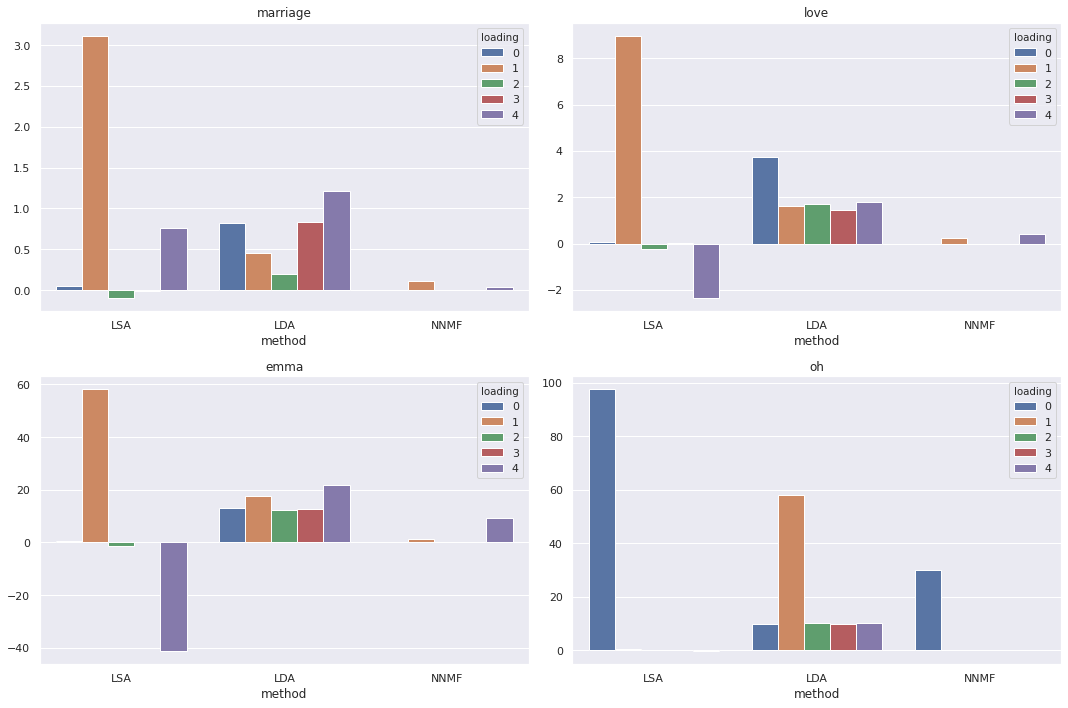

In [68]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")


plt.figure(figsize=(15,10))

for i, word in enumerate(targetwords):
    plt.subplot(2,2,i+1)
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
plt.tight_layout()
plt.show()


LSA is the method most likely to have high loadings on more than one topic for the same word.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.


In [57]:
wordloadings

,marriage,love,emma,oh,method,loading
0,4.752595e-02,7.259853e-02,5.833739e-01,9.760689e+01,LSA,0
1,3.112729e+00,8.980274e+00,5.812859e+01,5.248886e-01,LSA,1
2,-9.304916e-02,-2.325074e-01,-1.341336e+00,-6.599283e-03,LSA,2
3,-1.141780e-02,4.425106e-02,-1.371428e-02,2.393996e-03,LSA,3
4,7.558661e-01,-2.340274e+00,-4.133517e+01,-3.330612e-01,LSA,4
0,8.272886e-01,3.746778e+00,1.306030e+01,9.934936e+00,LDA,0
1,4.585479e-01,1.643047e+00,1.761684e+01,5.798341e+01,LDA,1
2,1.962002e-01,1.709220e+00,1.219878e+01,1.006170e+01,LDA,2
3,8.288008e-01,1.449475e+00,1.253845e+01,9.793099e+00,LDA,3
4,1.213051e+00,1.814609e+00,2.171680e+01,1.021564e+01,LDA,4
